In [85]:
import pandas as pd
from neo.io import AxonIO
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
def DataFrameNameToString(df):
    # Get the variable name of the DataFrame as a string
    for name, var in globals().items():
        if var is df:
            return name

In [11]:
def ABFreader(filelocation): # this function will transform ABF files into dataframes
    # Open the ABF file using AxonIO from the neo package
    fh = AxonIO(filename=filelocation)
    
    # Read the segments from the file
    segments = fh.read_block().segments
    
    # Extract the analog signals from the first segment
    analog_signals_ls = segments[0].analogsignals
    
    # Create an empty DataFrame to store the ABF data
    df = pd.DataFrame()
    
    # Create an empty list to store the time values
    list=[]
    
    # Initialize a time counter
    tc=0
    
    # Read a single segment from the file
    seg = fh.read_segment()
    
    # Loop to populate the time list
    while tc < len(seg.analogsignals[0]):
        list.append(tc)
        tc=tc+1
        
    # Create a DataFrame from the time list
    df = pd.DataFrame (list, columns = ['trash'])
    
    # Add columns to the DataFrame using the analog signals
    df['Vm_prime'] = analog_signals_ls[0]
    df['Im_sec'] = analog_signals_ls[1]
    df['Photodiod'] = analog_signals_ls[3]
    
    # Split the third analog signal into two channels
    channel_splitter=np.split(analog_signals_ls[2], 4, axis=1) #if you added more channels to clampex zou have to change it here 
    
    # Add the two channels to the DataFrame as separate columns
    df['Trigger'] =  channel_splitter[0][:]
    df['AirPuff'] =  channel_splitter[1][:]
    df['TrigWings '] =  channel_splitter[2][:]
    df['TrigEyes'] =  channel_splitter[3][:]
    

    
    
    # Drop the 'trash' column from the DataFrame
    df=df.drop(columns=["trash"])
    return df

# File paths

In [9]:
file_path_11=r"D:\230919_firstRecordingsinFlight\5attempt\rec2\2023_09_19_0005.abf"
file_path_2=r"D:\230923_Patch\2ndPrep\1strecording\2023_09_22_0000.abf"
file_path_3=r"D:\230923_Patch\3rprep\2ndattempt\2ndrecording\2023_09_22_0003.abf"
file_path_4=r"D:\231011_Patch\311\2023_10_11_0000.abf"


from glob import glob
file_path=glob(r"C:\Users\fenklab\Desktop\SampleData\*.abf")

In [10]:
file_path

['C:\\Users\\fenklab\\Desktop\\SampleData\\2023_10_31_0001.abf',
 'C:\\Users\\fenklab\\Desktop\\SampleData\\2023_11_20_0001.abf']

In [32]:
df_list=[]
for fp in file_path:
    df = ABFreader(fp)
    data_dic = {'filename':fp,'data':df}

    df_list.append(data_dic )

In [31]:
df_list[0]["data"]

,Vm_prime,Im_sec,Photodiod,Trigger,AirPuff,TrigWings,TrigEyes
0,1.586914,0.579834,0.085144,4.963989,4.986267,0.067749,0.069275
1,0.000000,0.610352,0.085144,4.960022,4.981689,0.068359,0.069885
2,-24.536131,0.549316,0.094910,4.957581,4.979248,0.067139,5.061340
3,-0.488281,0.579834,0.094604,4.966736,4.988708,0.067749,5.061646
4,-0.488281,0.579834,0.094299,4.962769,4.984436,0.068054,5.062561
...,...,...,...,...,...,...,...
3725307,-0.976562,0.488281,0.077209,4.963074,4.985962,0.071106,0.072327
3725308,-1.098633,0.488281,0.077209,4.948730,4.971619,0.069885,0.071411
3725309,-0.976562,0.488281,0.077820,4.956360,4.978638,0.070496,0.071716
3725310,-1.586914,0.457764,0.078125,4.965515,4.988708,0.070496,0.072021


# Add a time column

In [104]:
def add_time_abf(df, sampling_rate=10000.0):
    time_seconds = pd.Series(range(len(df))) / sampling_rate
    time_milliseconds = time_seconds * 1000.0
    df['time_sec'] = time_seconds
    df['time_millisec'] = time_milliseconds
    

def SubstractJunctionPotential(df):
    df['Vm_corrected']=df['Vm_prime'] - 13



def sync_point_flash(dic, column_name='Trigger', x_axis_name = 'time_millisec' , adjustment=0, threshold_multiplier=8):
    df=dic["data"]
    filename=dic["filename"]
    median_intensity = np.nanmedian(df[column_name])
    q1 = np.nanpercentile(df[column_name], 25)
    q3 = np.nanpercentile(df[column_name], 75)
    iqr_value = q3 - q1
    thresh_intensity = median_intensity - threshold_multiplier * iqr_value
    thresh_intensity = thresh_intensity-adjustment  # for noisy recordings

    fig, axs = plt.subplots(1,2)

    axs[0].plot(df[column_name])
    axs[0].axhline(y=thresh_intensity, color='r')
    axs[0].set_title('Full View %s'%filename)
    #plt.show()

    first_frame_number = np.where(df[column_name] < thresh_intensity)[0][0]

    axs[1].plot(df[column_name][first_frame_number - 2:first_frame_number + 2])
    axs[1].axhline(y=thresh_intensity, color='r')
    axs[1].axvline(x=first_frame_number, color='g')
    #axs[1].set_title('Zoom In %s'%filename)

    #save 
    filepath=os.path.dirname(filename)
    

    output_file = 'Analysis\Preprocessing\ABF\FirstFlashSync%s.pdf'%os.path.split(filename)[1]

    full_output_file = os.path.join(filepath, output_file)

    plt.savefig(full_output_file, format='pdf')

    
    plt.show()

    return first_frame_number

def create_analysis_folder_preprocessing(dic):
    # for filenames in dic
    # extract path of filename
    filename=dic["filename"]
    
    filepath=os.path.dirname(filename)

    # make new folder in path
    new_folder='Analysis\Preprocessing\ABF'

    os.makedirs(os.path.join(filepath, new_folder), exist_ok=True)#in case there are already analysis folders 


In [105]:
for data_dic in df_list:
    add_time_abf(data_dic["data"])
    SubstractJunctionPotential(data_dic["data"])
    create_analysis_folder_preprocessing(data_dic)


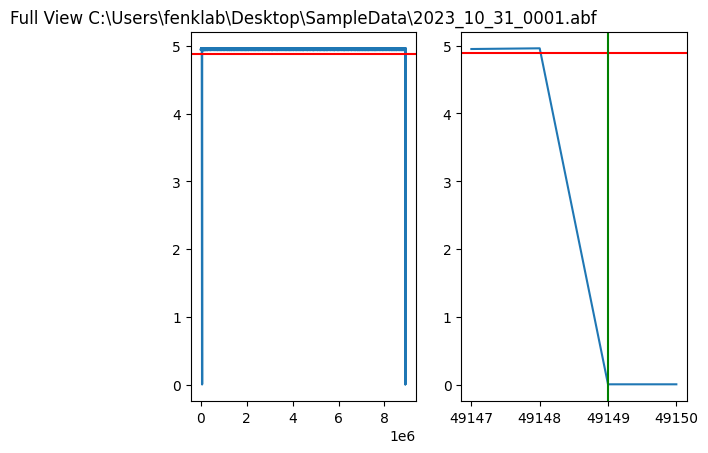

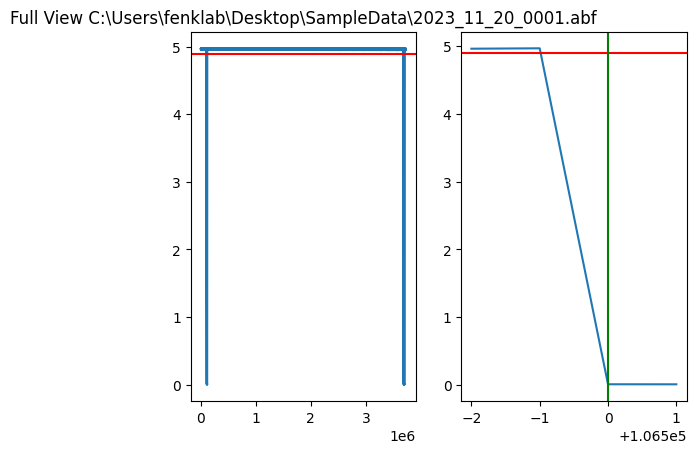

In [106]:
for data_dic in df_list:
    data_dic['First_Syinc_flash']=sync_point_flash(data_dic)

# Find threshold for ABF files

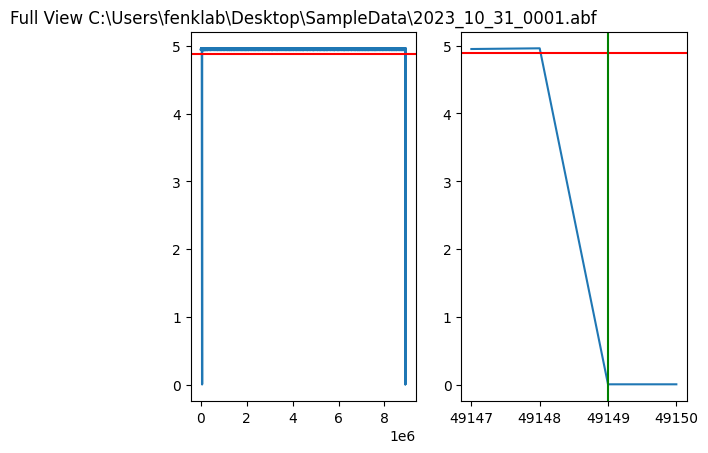

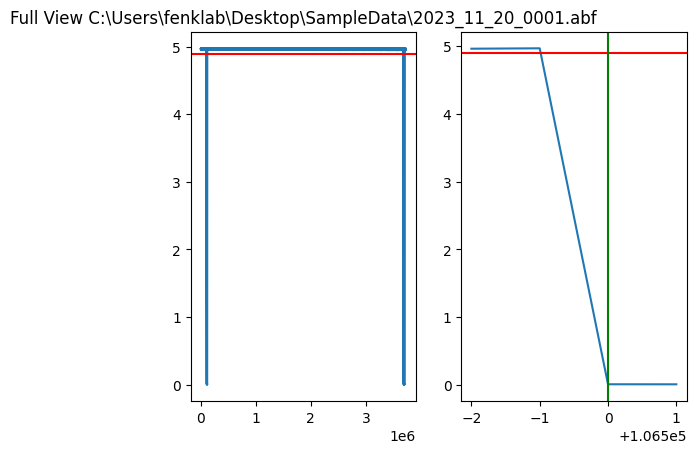

In [89]:
for data_dic in df_list:
    data_dic['First_Syinc_flash']=sync_point_flash(data_dic)
    

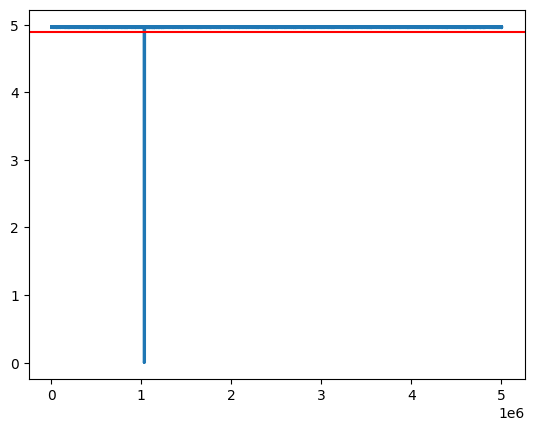

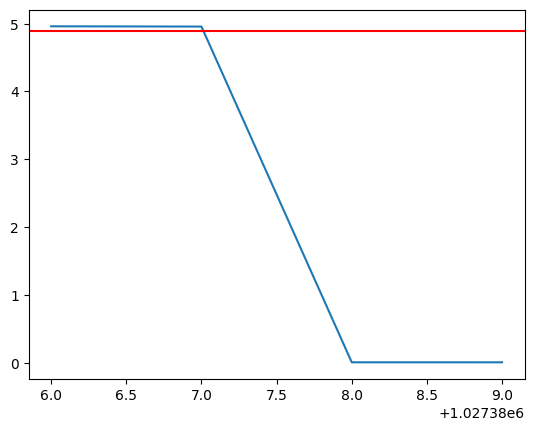

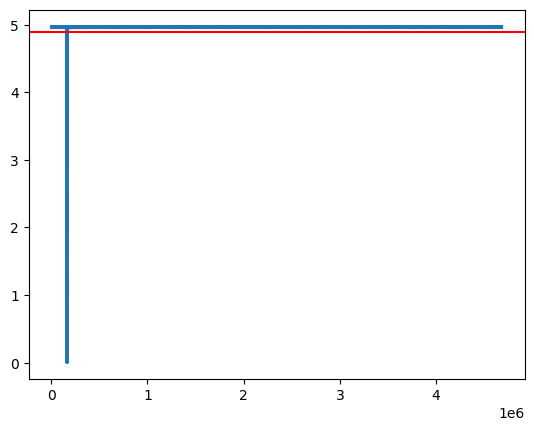

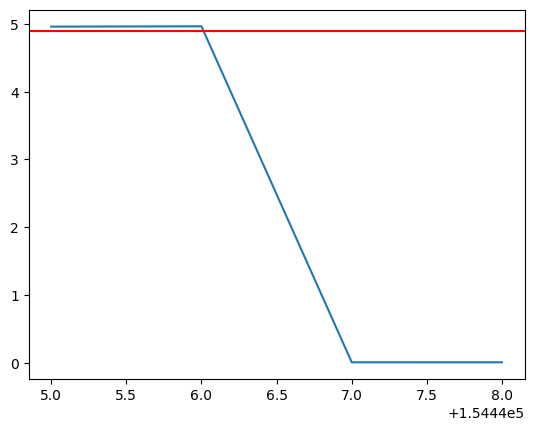

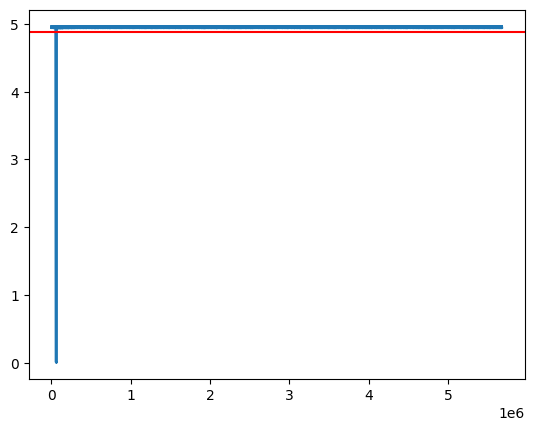

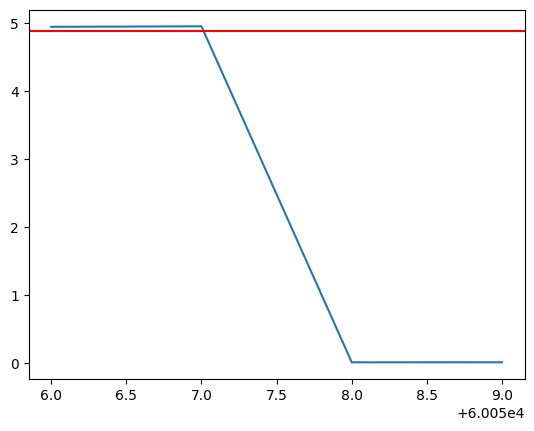

In [17]:
first_frame_df_abf_1=find_first_frame_abf(df_abf_1,'led',threshold_multiplier=8)
first_frame_df_abf_3=find_first_frame_abf(df_abf_3,'led',threshold_multiplier=8)
first_frame_df_abf_4=find_first_frame_abf(df_abf_4,'Trigger',threshold_multiplier=8)

In [18]:
df_abf_1['time_milliseconds_zero'] = (df_abf_1.index - first_frame_df_abf_1) / 10  # Assuming 10 Hz sampling rate, adjust as needed
df_abf_3['time_milliseconds_zero'] = (df_abf_3.index - first_frame_df_abf_3) / 10  # Assuming 10 Hz sampling rate, adjust as needed
df_abf_4['time_milliseconds_zero'] = (df_abf_4.index - first_frame_df_abf_4) / 10  # Assuming 10 Hz sampling rate, adjust as needed

# save df at .csv

In [19]:
def save_dataframe_to_csv(dataframe, file_path):
    dataframe.to_csv(file_path, index=False)



In [20]:
save_dataframe_to_csv(df_abf_1, r'D:\230919_firstRecordingsinFlight\5attempt\rec2\df_abf_1.csv')
save_dataframe_to_csv(df_abf_2, r'D:\230923_Patch\2ndPrep\1strecording\df_abf_2.csv')
save_dataframe_to_csv(df_abf_3, r'D:\230923_Patch\3rprep\2ndattempt\2ndrecording\df_abf_3.csv')
save_dataframe_to_csv(df_abf_4, r'D:\231011_Patch\311\df_abf_4.csv')


In [21]:
df_abf_1

,Vm_prime,Im_sec,led,Photodiod,Arduino,time_sec,time_millisec,Vm_corrected,time_milliseconds_zero
0,-40.838623,-7.324218,4.966431,-0.058289,-0.211487,0.0000,0.0,-53.838623,-102738.8
1,-40.899658,-7.934570,4.956055,-0.057678,-0.211182,0.0001,0.1,-53.899658,-102738.7
2,-40.942383,-7.934570,4.956665,-0.057373,-0.212097,0.0002,0.2,-53.942383,-102738.6
3,-41.003418,-7.934570,4.967651,-0.057678,-0.212402,0.0003,0.3,-54.003418,-102738.5
4,-41.027832,-8.544922,4.960022,-0.057983,-0.211182,0.0004,0.4,-54.027832,-102738.4
...,...,...,...,...,...,...,...,...,...
5007355,-38.745117,-7.934570,4.966736,-0.057678,-0.212097,500.7355,500735.5,-51.745117,397996.7
5007356,-38.739014,-7.324218,4.963684,-0.057373,-0.212097,500.7356,500735.6,-51.739014,397996.8
5007357,-38.751221,-6.713867,4.952393,-0.057373,-0.213013,500.7357,500735.7,-51.751221,397996.9
5007358,-38.775635,-7.934570,4.961853,-0.057678,-0.212097,500.7358,500735.8,-51.775635,397997.0


In [23]:
print(first_frame_df_abf_1, first_frame_df_abf_3, first_frame_df_abf_4)

1027388 154447 60058
